In [1]:
import preliz as pz
import arviz as az
import pymc as pm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Chapter Stuff

In [2]:
bikes=pd.read_csv('bikes.csv')

with pm.Model() as model_lb: 
    α = pm.Normal("α", mu=0, sigma=100) 
    β = pm.Normal("β", mu=0, sigma=10) 
    σ = pm.HalfCauchy("σ", 10) 
    μ = pm.Deterministic("μ", α + β * bikes['temperature']) 
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes['rented']) 
    idata_lb = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

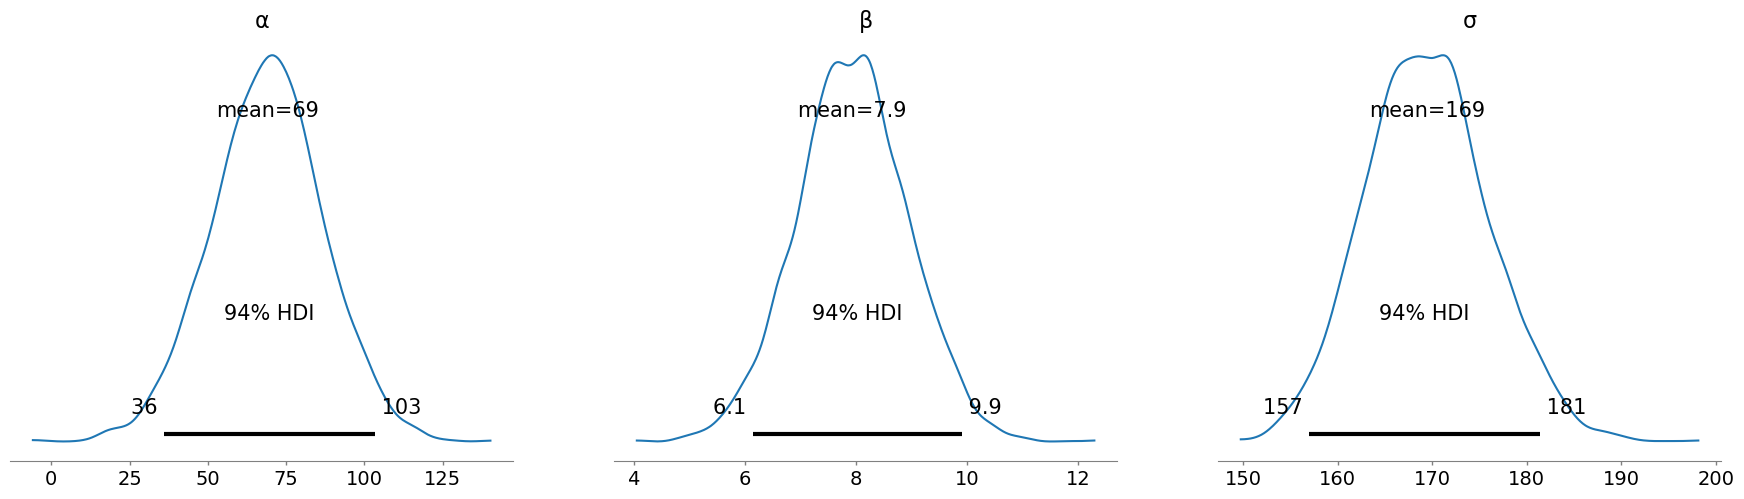

In [3]:
az.plot_posterior(idata_lb,var_names=['~μ'])

(-5.0, 35.0)

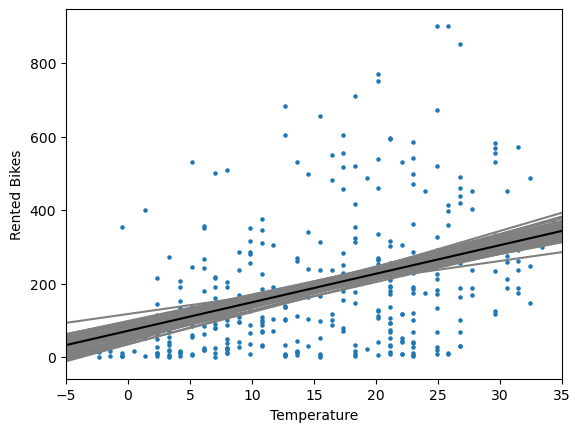

In [60]:
posterior = az.extract(idata_lb, num_samples=50) 
x_plot = xr.DataArray( 
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), 
    dims="plot_id" 
) 

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot 
lines = posterior["α"] + posterior["β"] * x_plot 
hdi_lines = az.hdi(idata_lb.posterior["μ"])


for i in range(0,len(x_plot)):
    plt.plot(x_plot,lines[i],color='gray')
plt.plot(x_plot,mean_line,label='Mean Prediction',color='black')
plt.scatter(bikes['temperature'],bikes['rented'],5)
plt.xlabel('Temperature')
plt.ylabel('Rented Bikes')
plt.xlim(-5,35)


(-5.0, 35.0)

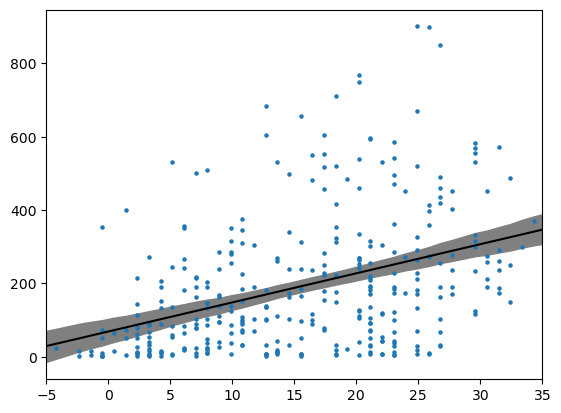

In [57]:
idx = np.argsort(bikes.temperature.values)
plt.fill_between(bikes['temperature'][idx],hdi_lines['μ'][:,0][idx],hdi_lines['μ'][:,1][idx],color='gray')
plt.plot(x_plot,mean_line,label='Mean Prediction',color='black')
plt.scatter(bikes['temperature'],bikes['rented'],5)
plt.xlim(-5,35)

In [72]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

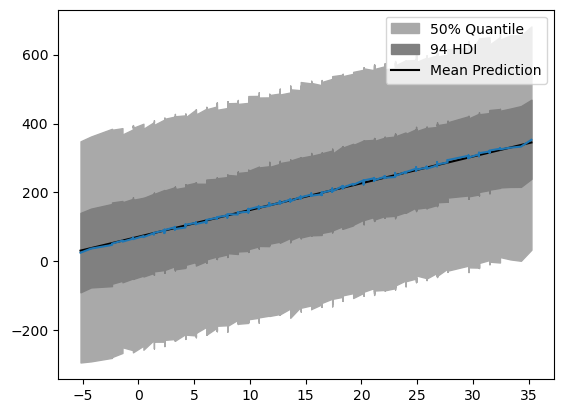

In [90]:
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile([0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"])
plt.fill_between(bikes['temperature'][idx],y_pred_q[0][idx],y_pred_q[1][idx],color='darkgray',label='50% Quantile')
plt.fill_between(bikes['temperature'][idx],y_pred_q[2][idx],y_pred_q[3][idx],color='gray',label='94 HDI')
plt.plot(x_plot,mean_line,label='Mean Prediction',color='black')
plt.plot(bikes['temperature'][idx],idata_lb.posterior_predictive['y_pred'].mean(dim=['chain','draw'])[idx])
plt.legend()

Negative Binomial and Bikes

In [3]:
bikes=pd.read_csv('bikes.csv')

with pm.Model() as model_neg:
    α = pm.Normal("α", mu=0, sigma=1) 
    β = pm.Normal("β", mu=0, sigma=10) 
    σ = pm.HalfCauchy("σ", 10) 
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes['temperature'])) 
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes['rented']) 
    idata_neg = pm.sample()
    pm.sample_posterior_predictive(idata_neg,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [y_pred]


Output()

array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>]],
      dtype=object)

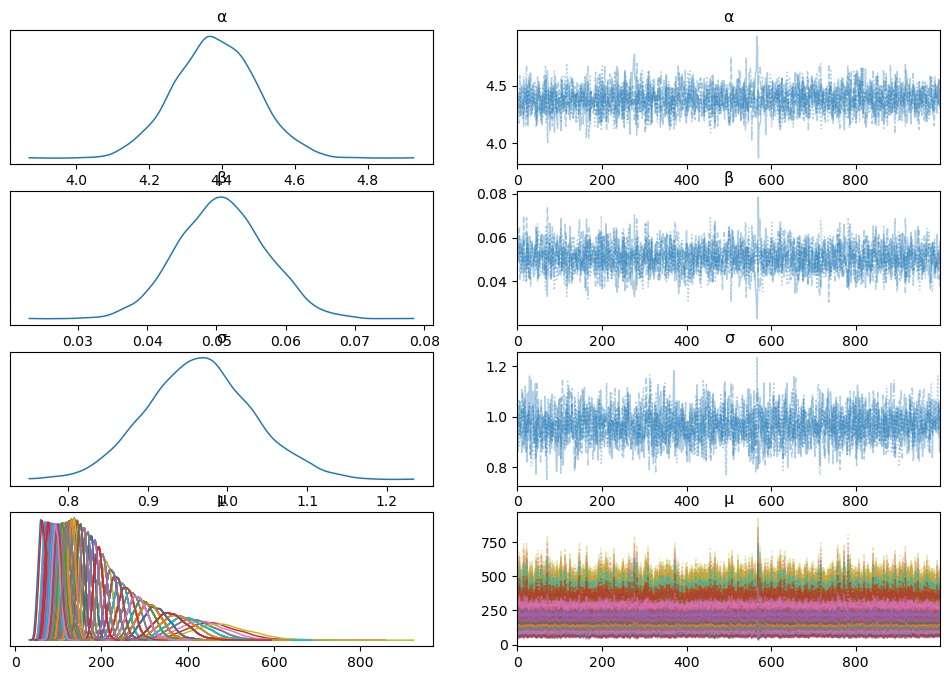

In [41]:
az.plot_trace(idata_neg,combined=True)

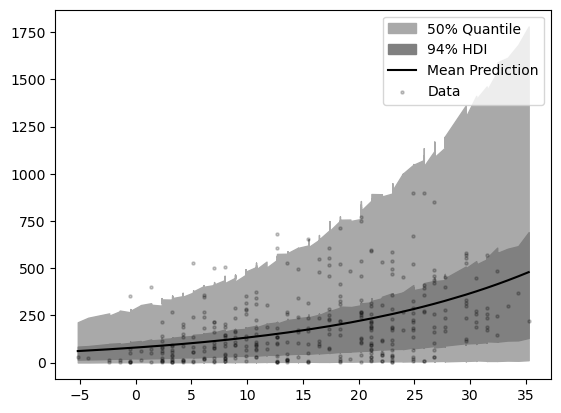

In [35]:
idx = np.argsort(bikes.temperature.values)
y_pred_q = idata_neg.posterior_predictive["y_pred"].quantile([0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"])
plt.fill_between(bikes['temperature'][idx],y_pred_q[0][idx],y_pred_q[1][idx],color='darkgray',label='50% Quantile')
plt.fill_between(bikes['temperature'][idx],y_pred_q[2][idx],y_pred_q[3][idx],color='gray',label='94% HDI')

mean_line=idata_neg.posterior['α'].mean(dim=['chain','draw']) + idata_neg.posterior['β'].mean(dim=['chain','draw'])*(bikes['temperature'].to_xarray())

plt.plot(bikes['temperature'][idx],np.exp(mean_line[idx]),label='Mean Prediction',color='black')
# plt.plot(bikes['temperature'][idx],idata_neg.posterior_predictive['y_pred'].mean(dim=['chain','draw'])[idx],color='black')
plt.scatter(bikes['temperature'],bikes['rented'],5,label='Data',color='black',alpha=0.2)
plt.legend()

<Axes: xlabel='y_pred'>

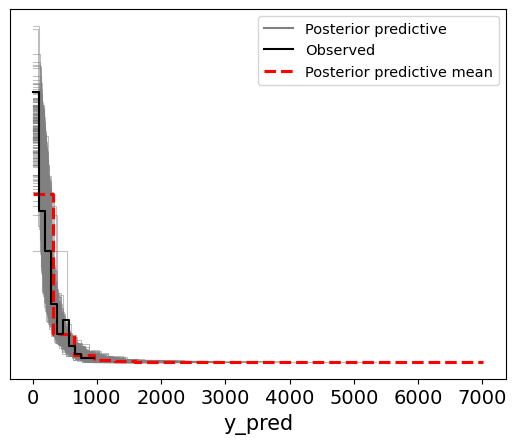

In [49]:
az.plot_ppc(idata_neg,num_pp_samples=200,alpha=0.5,colors=['gray','black','red'])

Logistic Regression

In [63]:
df=pd.read_csv('iris.csv')
iris=df[(df['species']=='setosa') | (df['species']=='versicolor')]

y_0=pd.Categorical(iris['species']).codes
x_0=iris['sepal_length'].values
x_c = x_0 - x_0.mean()

In [64]:
with pm.Model() as model_lrs: 
    α = pm.Normal("α", mu=0, sigma=1) 
    β = pm.Normal("β", mu=0, sigma=5) 
    μ = α + x_c * β 
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ)) 
    bd = pm.Deterministic("bd", -α / β) 
    yl = pm.Bernoulli("yl", p=θ, observed=y_0) 
 
    idata_lrs = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'bd'}>], dtype=object)

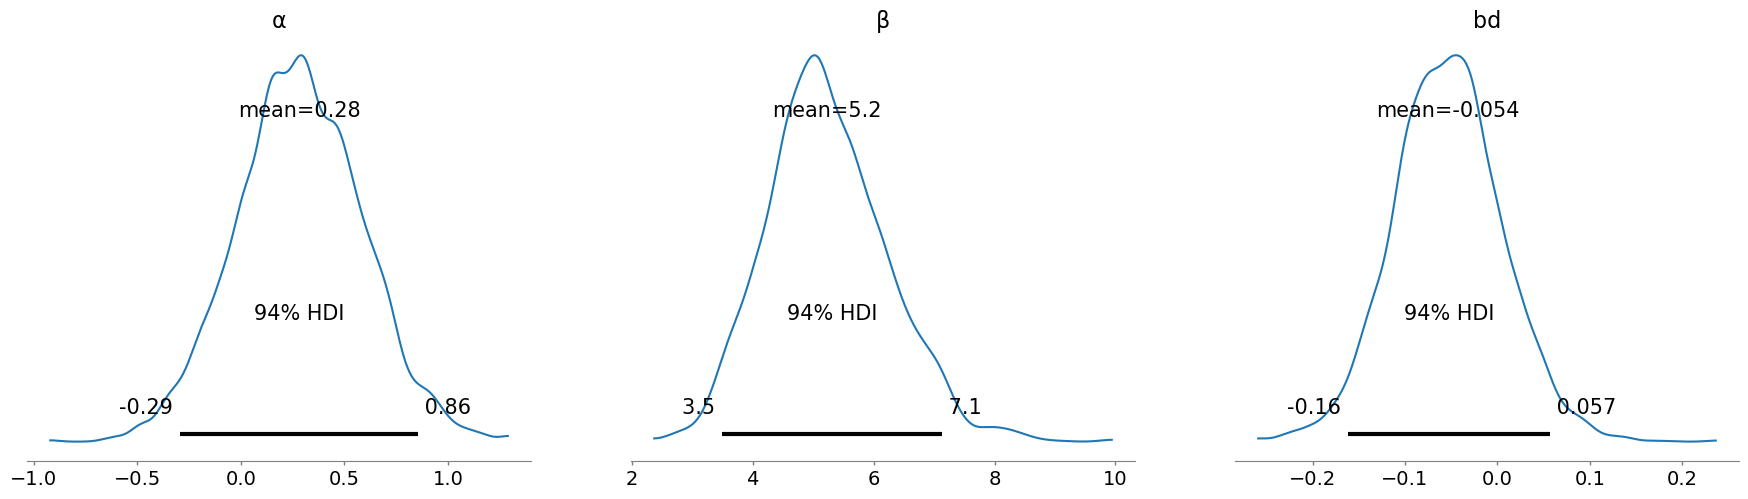

In [71]:
az.plot_posterior(idata_lrs,var_names=['~θ'])

In [73]:
with model_lrs:
    pm.sample_posterior_predictive(idata_lrs,extend_inferencedata=True)

Sampling: [yl]


Output()

In [76]:
idata_lrs

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

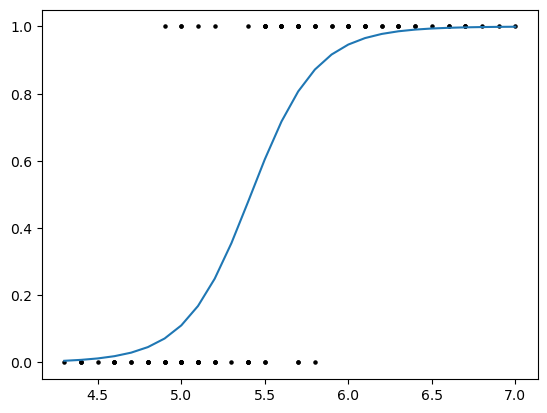

In [82]:
plt.scatter(x_0,y_0,5,color='black',label='Data')
idx=np.argsort(x_0)
plt.plot(x_0[idx],idata_lrs.posterior["θ"].mean(dim=['chain','draw'])[idx])

Variable Variance

In [105]:
data=pd.read_csv('babies.csv')

In [106]:
with pm.Model() as model_vv: 
    x_shared = pm.MutableData("x_shared", data.month.values.astype(float)) 
    α = pm.Normal("α", sigma=10) 
    β = pm.Normal("β", sigma=10) 
    γ = pm.HalfNormal("γ", sigma=10) 
    δ = pm.HalfNormal("δ", sigma=10) 
 
    μ = pm.Deterministic("μ", 𝛼 + β * x_shared**0.5) 
    σ = pm.Deterministic("σ", γ + δ * x_shared) 
 
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.length) 
 
    idata_vv = pm.sample()

C:\Users\varun\anaconda3\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


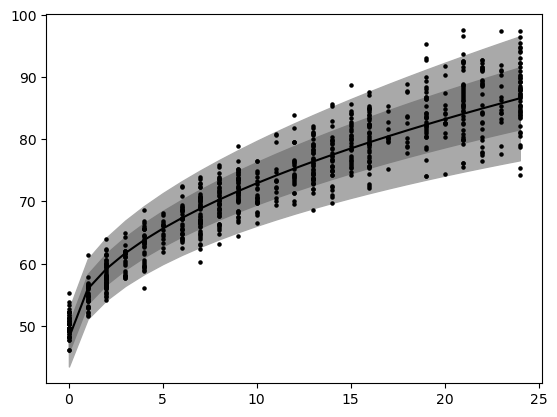

In [108]:


plt.plot(data.month,idata_vv.posterior['μ'].mean(dim=['chain','draw']),color='black')
# mean_q=data.month,idata_vv.posterior['μ'].quantile([])

mu_sd_up=idata_vv.posterior['μ'].mean(dim=['chain','draw']).rename({'μ_dim_0': 'dim_0'})+idata_vv.posterior['σ'].mean(dim=['chain','draw']).rename({'σ_dim_0': 'dim_0'})
mu_sd_low=idata_vv.posterior['μ'].mean(dim=['chain','draw']).rename({'μ_dim_0': 'dim_0'})-idata_vv.posterior['σ'].mean(dim=['chain','draw']).rename({'σ_dim_0': 'dim_0'})

mu_2sd_up=idata_vv.posterior['μ'].mean(dim=['chain','draw']).rename({'μ_dim_0': 'dim_0'})+2*idata_vv.posterior['σ'].mean(dim=['chain','draw']).rename({'σ_dim_0': 'dim_0'})
mu_2sd_low=idata_vv.posterior['μ'].mean(dim=['chain','draw']).rename({'μ_dim_0': 'dim_0'})-2*idata_vv.posterior['σ'].mean(dim=['chain','draw']).rename({'σ_dim_0': 'dim_0'})

plt.fill_between(data.month,mu_2sd_up,mu_2sd_low,color='darkgray')
plt.fill_between(data.month,mu_sd_up,mu_sd_low,color='gray')
plt.scatter(data.month,data.length,5,color='black')



In [117]:
with model_vv: 
    pm.set_data({"x_shared": [0.5]}) 
    ppc = pm.sample_posterior_predictive(idata_vv) 
    y_ppc = ppc.posterior_predictive["y_pred"].stack(sample=("chain", "draw"))

Sampling: [y_pred]


Output()

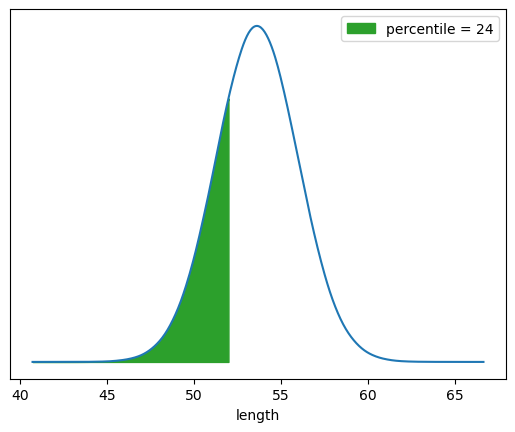

In [119]:
ref = 52
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentile = {:2d}".format(percentile),
    color="C2",
)
plt.xlabel("length")
plt.yticks([])
plt.legend()

Heirarchial Linear Regression

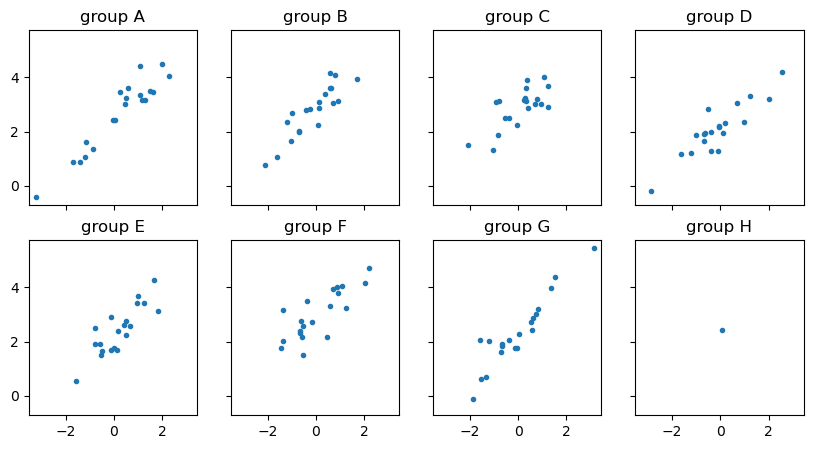

In [3]:
N = 20
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(groups)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_title(f"group {g}")

    j += N
    k += N



In [9]:
##Non Heirarchial Model
coords={'group':groups}

with pm.Model(coords=coords) as unpooled_model:
    α=pm.Normal('α', sigma=10,dims='group')
    β=pm.Normal('β', sigma=10,dims='group')
    σ=pm.HalfNormal('σ',sigma=5)
    μ=pm.Deterministic('μ', α[idx]+β[idx]*x_m)
    y=pm.Normal('y',mu=μ,sigma=σ,observed=y_m)
    idata_up=pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

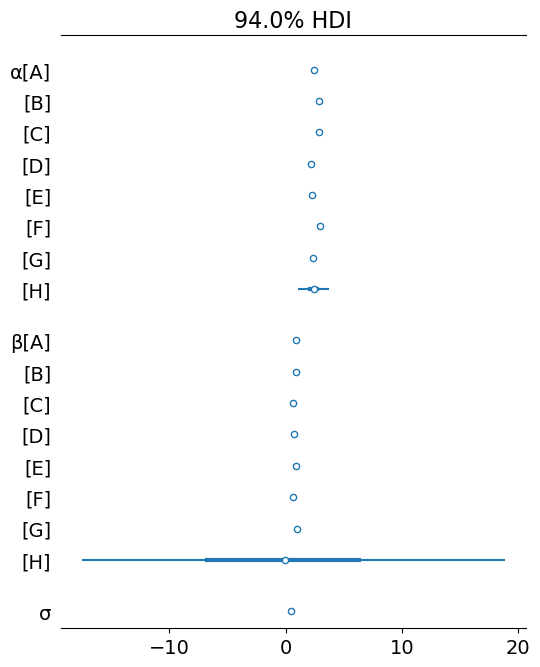

In [12]:
az.plot_forest(idata_up,combined=True,var_names=['~μ'])

In [14]:
with pm.Model(coords=coords) as hierarchical_centered: 
    # hyperpriors 
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1) 
    α_σ = pm.HalfNormal("α_σ", 5) 
    β_μ = pm.Normal("β_μ", mu=0, sigma=1) 
    β_σ = pm.HalfNormal("β_σ", sigma=5) 
 
    # priors 
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group") 
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="group") 
    σ = pm.HalfNormal("σ", 5) 
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m) 
 
    idata_cen = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
with pm.Model(coords=coords) as hierarchical_non_centered: 
    # hyperpriors 
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1) 
    α_σ = pm.HalfNormal("α_σ", 5) 
    β_μ = pm.Normal("β_μ", mu=0, sigma=1) 
    β_σ = pm.HalfNormal("β_σ", sigma=5) 
 
    # priors 
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group") 
 
    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="group") 
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="group") 
 
    σ = pm.HalfNormal("σ", 5) 
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m) 
 
    idata_ncen = pm.sample(target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β_offset, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Multiple Linear Regression

In [20]:
bikes=pd.read_csv('bikes.csv')
with pm.Model() as model_mlb: 
    α = pm.Normal("α", mu=0, sigma=1) 
    β0 = pm.Normal("β0", mu=0, sigma=10) 
    β1 = pm.Normal("β1", mu=0, sigma=10) 
    σ = pm.HalfNormal("σ", 10) 
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + 
                                              β1 * bikes.hour)) 
    _ = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented) 
 
    idata_mlb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


### Exercises

1. Using the howell dataset (available at https://github.com/aloctavodia/BAP3), create a linear model of the weight (x) against the height (y). Exclude subjects that are younger than 18. Explain the results

In [27]:
data=pd.read_csv('howelll.csv')
data=data[data.age>=18]
x_0=data.weight.values

with pm.Model() as howell_model:
    x_shared = pm.MutableData("x_shared", x_0.astype(float),dims='wt') 
    
    #Priors
    α=pm.Normal('α',mu=0,sigma=5)
    β=pm.Normal('β',mu=0,sigma=10)
    μ=pm.Deterministic('μ',α+β*x_shared,dims='wt')
    σ=pm.HalfNormal('σ',2)
    
    #Likelihood
    y=pm.Normal('y',mu=μ,sigma=σ,observed=data.height,dims='wt')

    idata=pm.sample()
    

C:\Users\varun\anaconda3\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


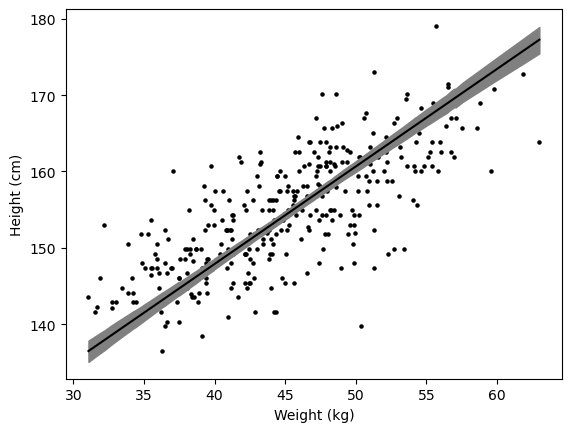

In [5]:
plt.scatter(data.weight,data.height,5,color='black')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')


idx=np.argsort(x_0)

y_mean=idata.posterior['α'].mean() + idata.posterior['β'].mean()*data.weight.to_xarray()[idx]

plt.plot(x_0[idx],y_mean,color='black')

hdi_lines = az.hdi(idata.posterior["μ"])
plt.fill_between(x_0[idx],hdi_lines['μ'].sel(hdi='lower')[idx],hdi_lines['μ'].sel(hdi='higher')[idx],color='gray')


2. For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their heights. Using the model from the previous exercise, predict the height for each subject, together with their 50% and 94% HDIs. Tip: Use pm.MutableData.

In [28]:
with howell_model:
    pm.set_data({'x_shared':np.array([45.73, 65.8, 54.2, 32.59])})
    ppc=pm.sample_posterior_predictive(idata)
    y_ppc = ppc.posterior_predictive["y"].stack(sample=("chain", "draw"))

Sampling: [y]


Output()

In [22]:
y_ppc.values[0]

array([159.19140193, 159.13142544, 159.99557079, ..., 150.58757368,
       151.28308931, 149.72189956])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

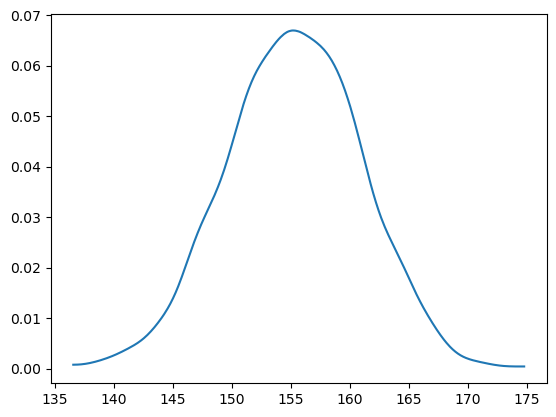

In [26]:
grid, pdf = az.stats.kde(y_ppc.values[0])
hdi_pts=az.stats.hdi(y_ppc.values[0])
plt.plot(grid, pdf,label='Posterior Distribution')
plt.fill_betweenx([min(pdf),max(pdf)],hdi_pts[:,0].mean(),hdi_pts[:,1].mean(),alpha=0.5,label='HDI 94%')

plt.xlabel("Height (cm)")
plt.title('Posterior Predictive for Weight 45.73kgs')
plt.yticks([])
plt.legend()
plt.show()

grid, pdf = az.stats.kde(y_ppc.values[1])
hdi_pts=az.stats.hdi(y_ppc.values[1])
plt.plot(grid, pdf,label='Posterior Distribution')
plt.fill_betweenx([min(pdf),max(pdf)],hdi_pts[:,0].mean(),hdi_pts[:,1].mean(),alpha=0.5,label='HDI 94%')

plt.xlabel("Height (cm)")
plt.title('Posterior Predictive for Weight 45.73kgs')
plt.yticks([])
plt.legend()
plt.show()

grid, pdf = az.stats.kde(y_ppc.values[2])
hdi_pts=az.stats.hdi(y_ppc.values[2])
plt.plot(grid, pdf,label='Posterior Distribution')
plt.fill_betweenx([min(pdf),max(pdf)],hdi_pts[:,0].mean(),hdi_pts[:,1].mean(),alpha=0.5,label='HDI 94%')

plt.xlabel("Height (cm)")
plt.title('Posterior Predictive for Weight 45.73kgs')
plt.yticks([])
plt.legend()
plt.show()

grid, pdf = az.stats.kde(y_ppc.values[3])
hdi_pts=az.stats.hdi(y_ppc.values[3])
plt.plot(grid, pdf,label='Posterior Distribution')
plt.fill_betweenx([min(pdf),max(pdf)],hdi_pts[:,0].mean(),hdi_pts[:,1].mean(),alpha=0.5,label='HDI 94%')

plt.xlabel("Height (cm)")
plt.title('Posterior Predictive for Weight 45.73kgs')
plt.yticks([])
plt.legend()
plt.show()

3. Repeat exercise 1, this time including those below 18 years old. Explain the results.

In [168]:
data=pd.read_csv('howelll.csv')
x_0=data.weight.values
with pm.Model() as howell_model_all:
    x_shared = pm.MutableData("x_shared", x_0.astype(float)) 
    
    #Priors
    α=pm.Normal('α',mu=0,sigma=5)
    β=pm.Normal('β',mu=0,sigma=10)
    μ=pm.Deterministic('μ',α+β*x_shared)
    σ=pm.HalfNormal('σ',2)
    
    #Likelihood
    y=pm.Normal('y',mu=μ,sigma=σ,observed=data.height)

    idata_all=pm.sample()
    

C:\Users\varun\anaconda3\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


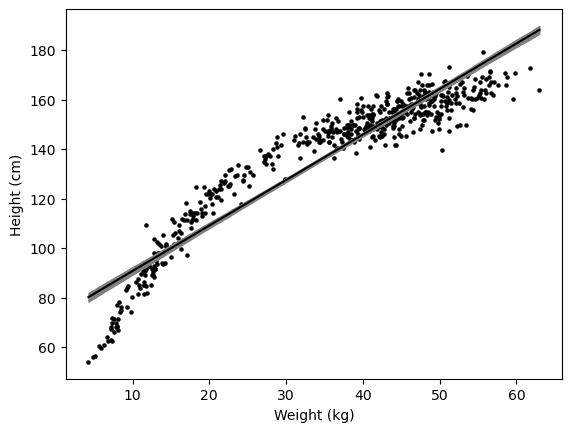

In [171]:
plt.scatter(data.weight,data.height,5,color='black')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')

idx=np.argsort(x_0)

y_mean=idata_all.posterior['α'].mean() + idata_all.posterior['β'].mean()*data.weight.to_xarray()[idx]

plt.plot(x_0[idx],y_mean,color='black')

hdi_lines = az.hdi(idata_all.posterior["μ"])

plt.fill_between(x_0[idx],hdi_lines['μ'].sel(hdi='lower')[idx],hdi_lines['μ'].sel(hdi='higher')[idx],color='gray')


4. It is known for many species that weight does not scale with height, but with the logarithm of the weight. Use this information to fit the howell data (including subjects from all ages).

In [172]:
data=pd.read_csv('howelll.csv')
x_0=np.log(data.weight.values)

with pm.Model() as howell_model_log:
    x_shared = pm.MutableData("x_shared", x_0.astype(float)) 
    
    #Priors
    α=pm.Normal('α',mu=0,sigma=5)
    β=pm.Normal('β',mu=0,sigma=10)
    μ=pm.Deterministic('μ',α+β*x_shared)
    σ=pm.HalfNormal('σ',2)
    
    #Likelihood
    y=pm.Normal('y',mu=μ,sigma=σ,observed=data.height)

    idata_log=pm.sample()

C:\Users\varun\anaconda3\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


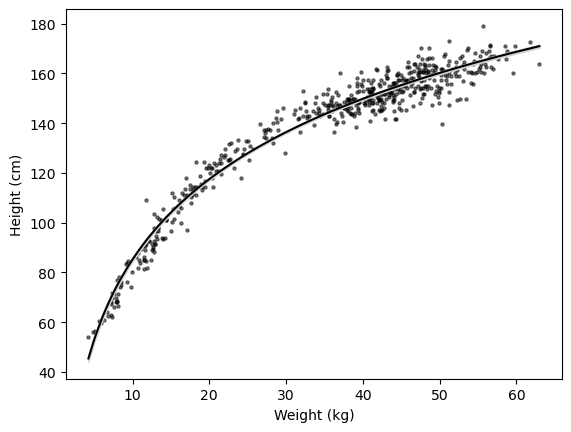

In [180]:
plt.scatter(data.weight,data.height,5,color='black',alpha=0.5)
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')

x_0=np.log(data.weight.values)

idx=np.argsort(x_0)

y_mean=idata_log.posterior['α'].mean() + idata_log.posterior['β'].mean()*xr.DataArray(x_0[idx])

plt.plot(np.exp(x_0[idx]),y_mean,color='black')

hdi_lines = az.hdi(idata_log.posterior["μ"])

plt.fill_between(np.exp(x_0[idx]),hdi_lines['μ'].sel(hdi='lower')[idx],hdi_lines['μ'].sel(hdi='higher')[idx],color='lightgray')

5. See the accompanying code model_t2 (and the data associated with it). Experiment with priors for ν, like the non-shifted Exponential and Gamma priors (they are commented on in the code). Plot the prior distribution to ensure that you understand them. An easy way to do this is to call the pm.sample_prior_predictive() function instead of pm.sample(). You can also use PreliZ.

6. Rerun model_lrs using the petal_length variable and then the petal_width variable. What are the main differences in the results? How wide or narrow is the 94% HDI in each case?

In [2]:
df=pd.read_csv('iris.csv')
iris=df[(df['species']=='setosa') | (df['species']=='versicolor')]

y_0=pd.Categorical(iris['species']).codes
x_0=iris['petal_length'].values
x_c = x_0 - x_0.mean()


with pm.Model() as model_lrs: 
    α = pm.Normal("α", mu=0, sigma=1) 
    β = pm.Normal("β", mu=0, sigma=5) 
    μ = α + x_c * β 
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ)) 
    bd = pm.Deterministic("bd", -α / β) 
    yl = pm.Bernoulli("yl", p=θ, observed=y_0) 
 
    idata_lrs = pm.sample()
    pm.sample_posterior_predictive(idata_lrs,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0, 0.5, 'θ')

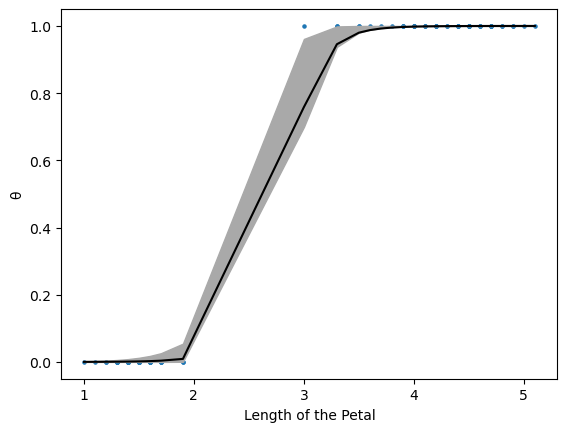

In [19]:
plt.scatter(x_0,y_0,5)
idx=np.argsort(x_0)
plt.plot(x_0[idx],idata_lrs.posterior['θ'].mean(dim=['chain','draw'])[idx],color='black',label='Data')

θ_q=idata_lrs.posterior['θ'].quantile([0.3,.97],dim=['chain','draw'])

plt.fill_between(x_0[idx],θ_q[0][idx],θ_q[1][idx],color='darkgray',,label='94% HDI')
plt.xlabel('Length of the Petal')
plt.ylabel('θ')

In [31]:
df=pd.read_csv('iris.csv')
iris=df[(df['species']=='setosa') | (df['species']=='versicolor')]

y_0=pd.Categorical(iris['species']).codes
x_0=iris['petal_width'].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_wrs: 
    α = pm.Normal("α", mu=0, sigma=1) 
    β = pm.Normal("β", mu=0, sigma=5) 
    μ = α + x_c * β 
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ)) 
    bd = pm.Deterministic("bd", -α / β) 
    yl = pm.Bernoulli("yl", p=θ, observed=y_0) 
 
    idata_wrs = pm.sample()
    pm.sample_posterior_predictive(idata_wrs,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [yl]


Output()

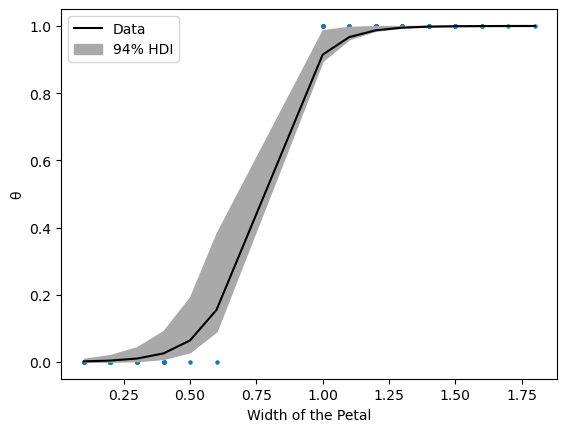

In [32]:
plt.scatter(x_0,y_0,5)
idx=np.argsort(x_0)
plt.plot(x_0[idx],idata_wrs.posterior['θ'].mean(dim=['chain','draw'])[idx],color='black',label='Data')

θ_q=idata_wrs.posterior['θ'].quantile([0.3,.97],dim=['chain','draw'])

plt.fill_between(x_0[idx],θ_q[0][idx],θ_q[1][idx],color='darkgray',label='94% HDI')
plt.xlabel('Width of the Petal')
plt.ylabel('θ')
plt.legend()

For the first Case, the HDI seems to increase with length. The HDI on the other hand decreases with incresing width.

7. Repeat the previous exercise, this time using a Student’s t-distribution as a weakly informative prior. Try different values of ν.

In [33]:
df=pd.read_csv('iris.csv')
iris=df[(df['species']=='setosa') | (df['species']=='versicolor')]

y_0=pd.Categorical(iris['species']).codes
x_0=iris['petal_length'].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_lrs: 
    α = pm.StudentT("α", mu=0, sigma=1,nu=2) 
    β = pm.StudentT("β", mu=0, sigma=5,nu=2) 
    μ = α + x_c * β 
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ)) 
    bd = pm.Deterministic("bd", -α / β) 
    yl = pm.Bernoulli("yl", p=θ, observed=y_0) 
 
    idata_lrs = pm.sample()
    pm.sample_posterior_predictive(idata_lrs,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 593 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [yl]


Output()

Text(0, 0.5, 'θ')

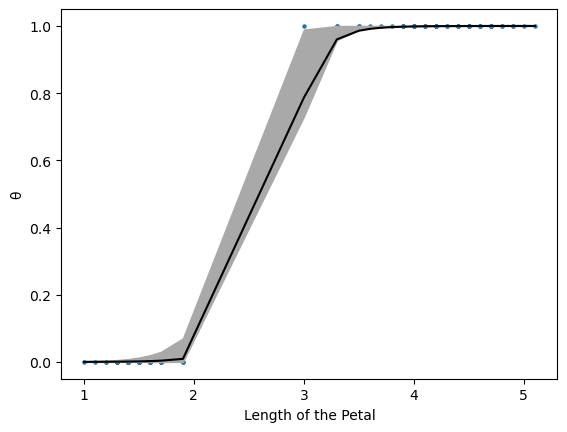

In [34]:
plt.scatter(x_0,y_0,5)
idx=np.argsort(x_0)
plt.plot(x_0[idx],idata_lrs.posterior['θ'].mean(dim=['chain','draw'])[idx],color='black',label='Data')

θ_q=idata_lrs.posterior['θ'].quantile([0.3,.97],dim=['chain','draw'])

plt.fill_between(x_0[idx],θ_q[0][idx],θ_q[1][idx],color='darkgray',label='94% HDI')
plt.xlabel('Length of the Petal')
plt.ylabel('θ')

In [40]:
df=pd.read_csv('iris.csv')
iris=df[(df['species']=='setosa') | (df['species']=='versicolor')]

y_0=pd.Categorical(iris['species']).codes
x_0=iris['petal_length'].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_lrs: 
    α = pm.StudentT("α", mu=0, sigma=1,nu=.5) 
    β = pm.StudentT("β", mu=0, sigma=5,nu=.5) 
    μ = α + x_c * β 
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ)) 
    bd = pm.Deterministic("bd", -α / β) 
    yl = pm.Bernoulli("yl", p=θ, observed=y_0) 
 
    idata_lrs = pm.sample()
    pm.sample_posterior_predictive(idata_lrs,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 876 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [yl]


Output()

Text(0, 0.5, 'θ')

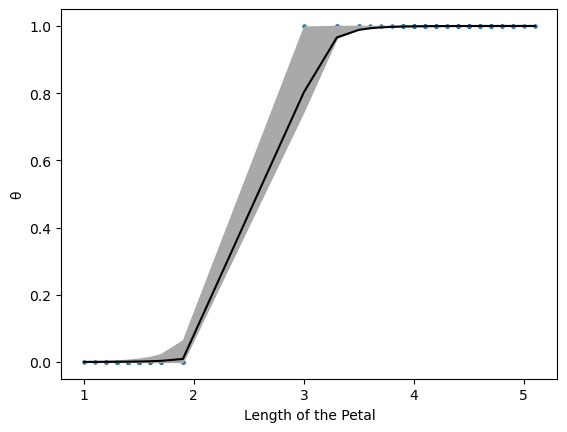

In [41]:
plt.scatter(x_0,y_0,5)
idx=np.argsort(x_0)
plt.plot(x_0[idx],idata_lrs.posterior['θ'].mean(dim=['chain','draw'])[idx],color='black',label='Data')

θ_q=idata_lrs.posterior['θ'].quantile([0.3,.97],dim=['chain','draw'])

plt.fill_between(x_0[idx],θ_q[0][idx],θ_q[1][idx],color='darkgray',label='94% HDI')
plt.xlabel('Length of the Petal')
plt.ylabel('θ')

A weaker prior is slightly increasing the variance in the predictions. However, not much cahanges are seen in the mean prediciton